In [15]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Dropout,
    Conv1D, MaxPooling1D, LSTM, concatenate
)
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [2]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [3]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

In [4]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [5]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/Colab Notebooks/machine-learning-practice/Machine-Learning-Programming/week10/data/UCI HAR/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/Colab Notebooks/machine-learning-practice/Machine-Learning-Programming/week10/data/UCI HAR/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [6]:
## 데이터 스케일링

# 1. Scaler 객체 생성
scaler = StandardScaler()

# 2. 3D 데이터를 2D로 변환 (samples * timesteps, features)
# (7352, 128, 9) -> (941056, 9)
n_samples_train, n_timesteps, n_features = trainX.shape
trainX_reshaped = trainX.reshape(-1, n_features)

# 3. train 데이터로 scaler를 'fit' (통계 계산) 및 'transform' (스케일링)
trainX_scaled_reshaped = scaler.fit_transform(trainX_reshaped)

# 4. 스케일링된 2D 데이터를 다시 3D로 변환
trainX = trainX_scaled_reshaped.reshape(n_samples_train, n_timesteps, n_features)

# 5. testX도 2D로 변환 (fit 없이 transform만 적용)
n_samples_test = testX.shape[0]
testX_reshaped = testX.reshape(-1, n_features)

# 6. 'fit' 없이 'transform'만 적용 (중요: train 데이터의 통계 사용)
testX_scaled_reshaped = scaler.transform(testX_reshaped)

# 7. testX를 다시 3D로 변환
testX = testX_scaled_reshaped.reshape(n_samples_test, n_timesteps, n_features)

In [7]:
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [8]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [9]:
# LSTM 모델 정의

# 입력 레이어
inputs = Input(shape=(n_timesteps, n_features))

# LSTM 레이어
lstm1 = LSTM(128)(inputs)
drop1 = Dropout(0.5)(lstm1)
dense1 = Dense(100, activation='relu')(drop1)
outputs = Dense(n_outputs, activation='softmax')(dense1)

## MODEL
lstm_model = Model(inputs, outputs)

lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,162 (328.76 KB)

 Trainable params: 84,162 (328.76 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model_history_lstm = lstm_model.fit(
    x=X_train,
    y=y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.5599 - loss: 1.1118 - val_accuracy: 0.8829 - val_loss: 0.3061
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8988 - loss: 0.3035 - val_accuracy: 0.9287 - val_loss: 0.1858
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9151 - loss: 0.2451 - val_accuracy: 0.8879 - val_loss: 0.2863
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9061 - loss: 0.2487 - val_accuracy: 0.9491 - val_loss: 0.1425
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9471 - loss: 0.1488 - val_accuracy: 0.9542 - val_loss: 0.1102
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9467 - loss: 0.1375 - val_accuracy: 0.9440 - val_loss: 0.1340
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9534 - loss: 0.1215 - val_accuracy: 0.9593 - val_loss: 0.1225
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9334 - loss: 0.1823 - val_accura

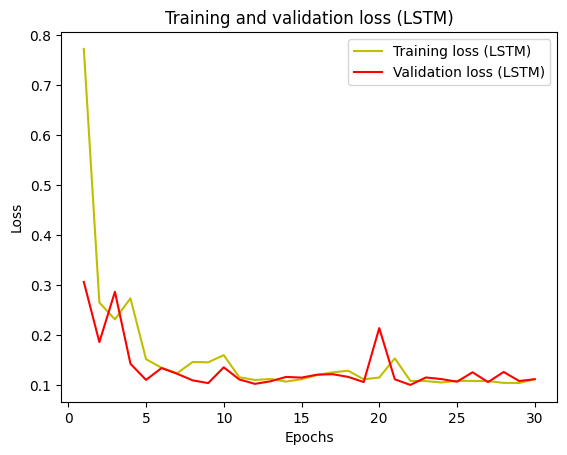

In [11]:
## LSTM 모델 학습 결과 시각화

loss = model_history_lstm.history['loss']
val_loss = model_history_lstm.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss (LSTM)')
plt.plot(epochs, val_loss, 'r', label='Validation loss (LSTM)')
plt.title('Training and validation loss (LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

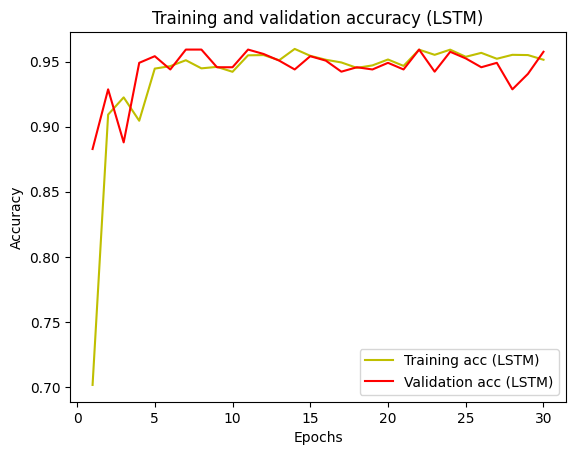

In [12]:
acc = model_history_lstm.history['accuracy']
val_acc = model_history_lstm.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc (LSTM)')
plt.plot(epochs, val_acc, 'r', label='Validation acc (LSTM)')
plt.title('Training and validation accuracy (LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


--- LSTM Model Evaluation ---
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Confusion Matrix (LSTM):
[[464   3  29   0   0   0]
 [  2 448  18   3   0   0]
 [  0  14 406   0   0   0]
 [  0   3   0 383 105   0]
 [  0   1   0  90 441   0]
 [  0   0   0   0  27 510]]

Accuracy (LSTM): 0.8998982015609094

Classification Report (LSTM):
              precision    recall  f1-score   support

           0       1.00      0.94      0.96       496
           1       0.96      0.95      0.95       471
           2       0.90      0.97      0.93       420
           3       0.80      0.78      0.79       491
           4       0.77      0.83      0.80       532
           5       1.00      0.95      0.97       537

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.90      0.90      0.90      2947



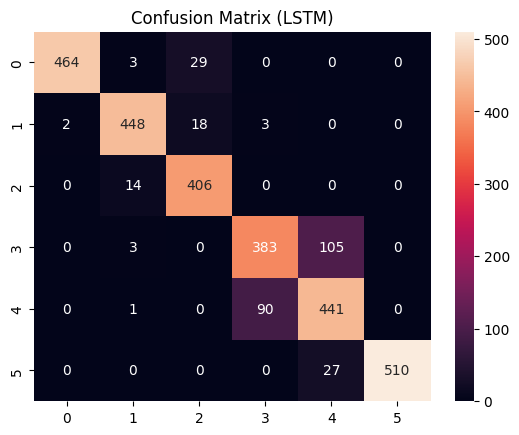

In [16]:
## LSTM 모델 평가

print("\n--- LSTM Model Evaluation ---")
pred_lstm = lstm_model.predict(testX)
pred_lstm_classes = np.argmax(pred_lstm, axis=-1)

cm_lstm = confusion_matrix(testy, pred_lstm_classes)
print("Confusion Matrix (LSTM):")
print(cm_lstm)
print("\nAccuracy (LSTM):", accuracy_score(testy, pred_lstm_classes))
print("\nClassification Report (LSTM):")
print(classification_report(testy, pred_lstm_classes))

sns.heatmap(cm_lstm, annot=True, fmt='d') # fmt='.2f'에서 'd' (정수)로 변경
plt.title("Confusion Matrix (LSTM)")
plt.show()